# 초기 세팅

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [ ]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cpu')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [ ]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [ ]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content', train=True, download=True, transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content', train=False, download=True, transform=CIFAR_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [ ]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

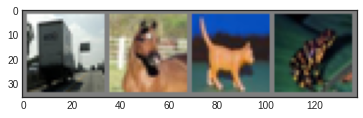

truck	 horse	 cat	 frog	


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [ ]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.layer1 = nn.Sequential(
          nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
      
      self.layer2 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
      )

      self.layer3 = nn.Sequential(
          nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, stride=2, padding=0),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      )

      self.flatten = nn.Flatten()

      self.fc1 = nn.Linear(256, 100)
      self.fc2 = nn.Linear(100,10)
    
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.fc2(x)

      x = x.view(-1, self.num_flat_features(x))

      return x

    def num_flat_features(self, x):
      size = x.size()[1:]
      num_features = 1
      for s in size:
        num_features *= s

      return num_features

In [ ]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
              ReLU-2            [4, 64, 32, 32]               0
         MaxPool2d-3            [4, 64, 16, 16]               0
            Conv2d-4             [4, 128, 8, 8]          32,896
              ReLU-5             [4, 128, 8, 8]               0
         MaxPool2d-6             [4, 128, 4, 4]               0
            Conv2d-7             [4, 256, 2, 2]         131,328
              ReLU-8             [4, 256, 2, 2]               0
         MaxPool2d-9             [4, 256, 1, 1]               0
          Flatten-10                   [4, 256]               0
           Linear-11                   [4, 100]          25,700
           Linear-12                    [4, 10]           1,010
Total params: 192,726
Trainable params: 192,726
Non-trainable params: 0
-------------------------------

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()               # 가중치 초기화

        outputs = myNet(inputs)             # y_pred
        loss = criterion(outputs, labels)   # 손실함수를 이용해서 loss계산
        loss.backward()                     # back-propagation
        optimizer.step()                        # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.3552846489101649
Epoch: 1, Batch: 4000, Loss: 1.3315625253915786
Epoch: 1, Batch: 6000, Loss: 1.2956492999941112
Epoch: 1, Batch: 8000, Loss: 1.2793624515458941
Epoch: 1, Batch: 10000, Loss: 1.237643658787012
Epoch: 1, Batch: 12000, Loss: 1.2106342357248068
Epoch: 2, Batch: 2000, Loss: 1.1359216731861235
Epoch: 2, Batch: 4000, Loss: 1.1114038894940168
Epoch: 2, Batch: 6000, Loss: 1.0783565103895962
Epoch: 2, Batch: 8000, Loss: 1.0889928253404797
Epoch: 2, Batch: 10000, Loss: 1.0394855386726558
Epoch: 2, Batch: 12000, Loss: 1.0341474251970648
Epoch: 3, Batch: 2000, Loss: 0.9446730489535258
Epoch: 3, Batch: 4000, Loss: 0.9670100185303018
Epoch: 3, Batch: 6000, Loss: 0.9402519432781264
Epoch: 3, Batch: 8000, Loss: 0.9674665452309419
Epoch: 3, Batch: 10000, Loss: 0.9469730632975698
Epoch: 3, Batch: 12000, Loss: 0.9409620249094441
Epoch: 4, Batch: 2000, Loss: 0.8346006479663775
Epoch: 4, Batch: 4000, Loss: 0.8135450317105278
Epoch: 4, Batch: 6000, Loss: 0.8672

## 모델의 저장 및 로드

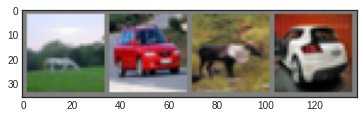

	horse 	car 	deer 	car


In [ ]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [ ]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [ ]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [ ]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                                              # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

68.76


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [ ]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 71.0%
Accuracy of car: 74.6%
Accuracy of bird: 66.9%
Accuracy of cat: 44.9%
Accuracy of deer: 53.4%
Accuracy of dog: 57.8%
Accuracy of frog: 82.3%
Accuracy of horse: 73.6%
Accuracy of ship: 78.3%
Accuracy of truck: 84.8%
